## IMPORTED MODULES

In [6]:
import os
import numpy as np                 
import pandas as pd                
import matplotlib.pyplot as plt
import seaborn as sns 
import librosa
import librosa.display
from IPython.display import Audio  
plt.style.use('default')
from scipy.signal import resample

# DATA PREPRATION MODULES
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# MODELING MODULES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM ,Activation

# # PREEDICTION MODULES
# from tensorflow.keras.models import load_model
# import sounddevice as sd
# from scipy.io.wavfile import write

#### LOADING THE DATA INTO DATAFRAME

In [8]:
paths = []
labels = []

for dirname, _, filenames in os.walk('D:/A_Graduate Project/Audio Part/Audio_Dataset'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)

        label = filename.split('_')[-1].split('.')[0].lower()
        labels.append(label)

df = pd.DataFrame()
df['path'] = paths
df['label'] = labels
df.head()

,path,label
0,D:/A_Graduate Project/Audio Part/Audio_Dataset...,ang
1,D:/A_Graduate Project/Audio Part/Audio_Dataset...,ang
2,D:/A_Graduate Project/Audio Part/Audio_Dataset...,ang
3,D:/A_Graduate Project/Audio Part/Audio_Dataset...,ang
4,D:/A_Graduate Project/Audio Part/Audio_Dataset...,ang


#### DATA ANALYSIS

In [9]:
print(df.label.value_counts())
print("Total Data :" , df.label.value_counts().sum())

label
ang    1923
dis    1923
fea    1923
hap    1923
sad    1923
neu    1703
Name: count, dtype: int64
Total Data : 11318


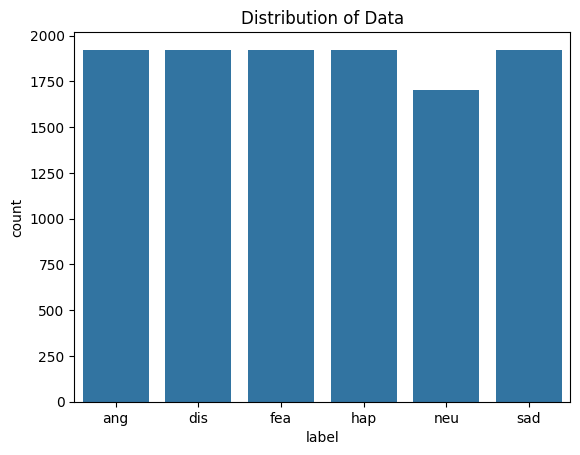

In [10]:
# Data Distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Data')
plt.show()

#### AUGMENTATION 

In [11]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, speed_factor)

# taking any example and checking for techniques.
path = path = 'D:/A_Graduate Project/Audio Part/Audio_Dataset/anger_emotion/0_ANG.wav'
data, sample_rate = librosa.load(path)

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

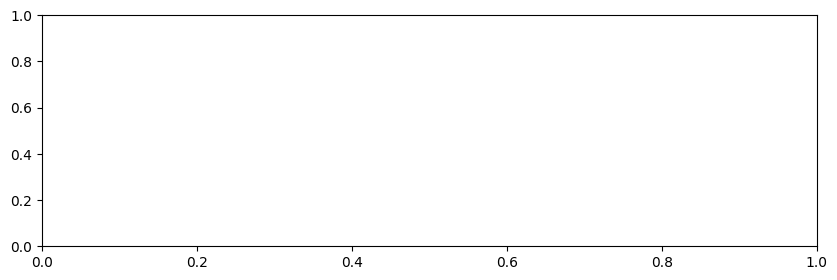

In [12]:
plt.figure(figsize=(10, 3))
x = noise(data) 
y = resample(x, len(data))
librosa.display.waveshow(y, sr=sample_rate)
plt.title('Waveplot with Noise', size=15)
plt.show()

# Playing the audio with added noise
Audio(y, rate=sample_rate)

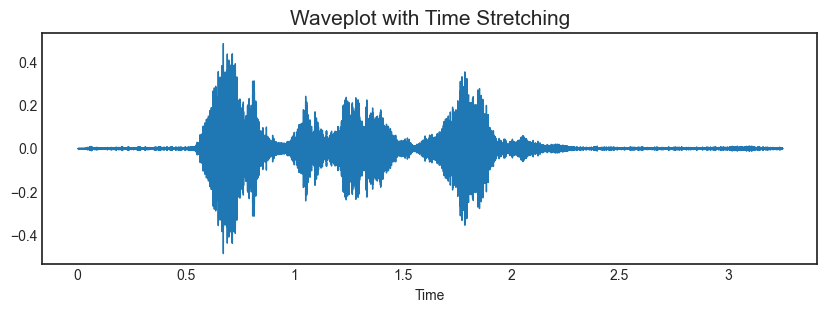

In [ ]:
def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate=rate)

plt.figure(figsize=(10, 3))
x = stretch(data)  # Assuming data is loaded or defined elsewhere
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Time Stretching', size=15)
plt.show()

# Playing the audio after time stretching
Audio(x, rate=sample_rate)

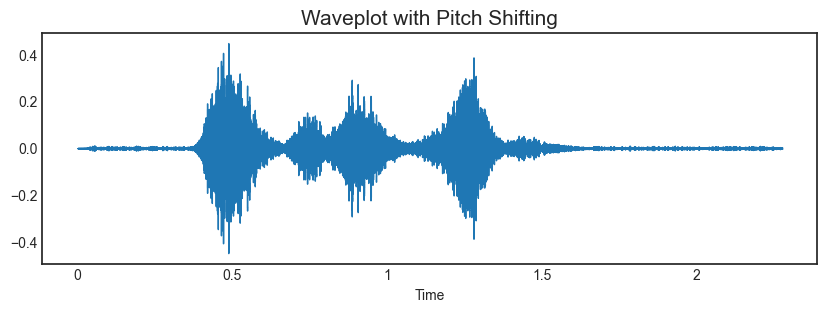

In [ ]:
def shift(data, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

plt.figure(figsize=(10, 3))
x = shift(data)  
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Pitch Shifting', size=15)
plt.show()

# Playing the audio after pitch shifting
Audio(x, rate=sample_rate)

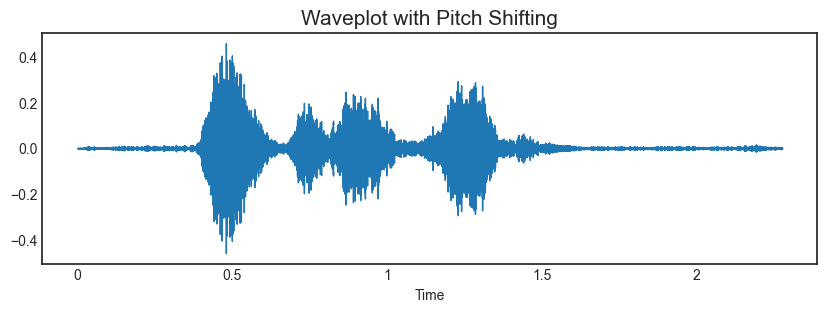

In [ ]:
def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, n_steps=int(pitch_factor * 12), sr=sampling_rate)

plt.figure(figsize=(10, 3))
x = pitch(data, sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Pitch Shifting', size=15)
plt.show()

# Playing the audio after pitch shifting
Audio(x, rate=sample_rate)

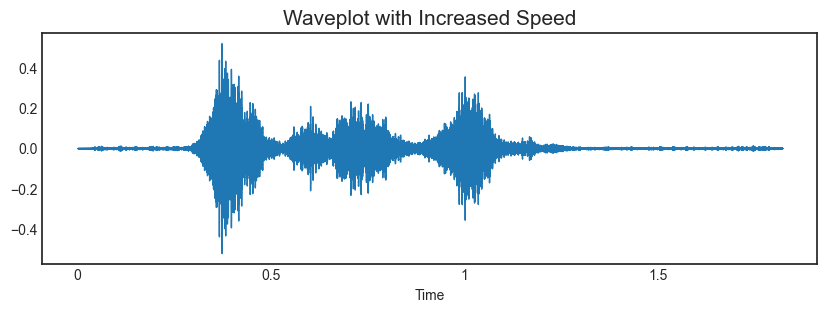

In [ ]:
def higher_speed(data, sample_rate, speed_factor=1.25):
    return librosa.effects.time_stretch(y=data, rate=speed_factor)
plt.figure(figsize=(10, 3))
x = higher_speed(data, sample_rate)  
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Increased Speed', size=15)
plt.show()

# Playing the audio after increasing the speed
Audio(x, rate=sample_rate)

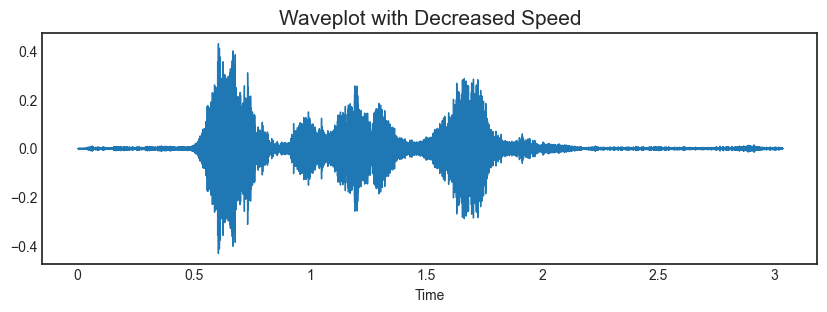

In [ ]:
def lower_speed(data, speed_factor=0.75):
    return librosa.effects.time_stretch(data, rate=speed_factor)

plt.figure(figsize=(10, 3))
x = lower_speed(data)  
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Decreased Speed', size=15)
plt.show()

# Playing the audio after decreasing the speed
Audio(x, rate=sample_rate)

#### FEATURE EXTRACTION 
##### USING MFCC (Mel-Frequency Cepstral Coefficients)

In [ ]:
def extract_features(data):
    
    result = np.array([])
    
    ## 58 n_mfcc    #sample_rate = 22050
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5, res_type='kaiser_fast')# approximate resampling method.
    
    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))
    
    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))
    
    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5)) 
    
    #speed up
    higher_speed_data = higher_speed(data, sample_rate)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))
    
    #speed down
    lower_speed_data = higher_speed(data, sample_rate)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))
    
    return result

In [ ]:
# #Extracting Features Using get_features Function and save them in CSV file.
# X, Y = [], []
# for path, emotion in zip(paths, labels): 
#     features = get_features(path)
#     for elem in features:
#         X.append(elem)
#         Y.append(emotion)

# # Convert to DataFrame
# features_df = pd.DataFrame(X)
# features_df['label'] = Y

# # Save to CSV
# features_df.to_csv('audio_features.csv', index=False)

In [13]:
# Load the Extracted Features for the Model 
features_df = pd.read_csv('D:/A_Graduate Project/Audio Part/audio_features.csv')

# Separate features and labels
X = features_df.drop('label', axis=1)
Y = features_df['label']

In [14]:
X = np.array(X)
Y = np.array(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y, shuffle = True)
# Then split training data into training and validation (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle = True)

print(f'X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}')
print(f'y_train: {len(y_train)}, y_val: {len(y_val)}, y_test: {len(y_test)}')

X_train: 50704, X_val: 12676, X_test: 15846
y_train: 50704, y_val: 12676, y_test: 15846


In [15]:
# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) 
X_test = scaler.transform(X_test)

# One-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = encoder.transform(y_val.reshape(-1, 1)).toarray()  
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

In [16]:
# Reshape data
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Output the shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((50704, 58, 1),
 (50704, 6),
 (12676, 58, 1),
 (12676, 6),
 (15846, 58, 1),
 (15846, 6))

##### MODEL
##### CNN-LSTM

In [17]:
model = keras.Sequential()
input_shape = (X_train.shape[1], X_train.shape[2])

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=3, input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layers
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Dense layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

num_classes = y_train.shape[1]
model.add(Dense(num_classes, activation='softmax'))

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)

c:\Users\Ahmed Abozaid\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 56, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 56, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 54, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 27, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 27, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,187,334 (4.53 MB)

 Trainable params: 1,185,542 (4.52 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [19]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=10, min_lr=0.000001)

In [20]:
history = model.fit(X_train, y_train, epochs=75, batch_size=32, callbacks = [rlrp], validation_data=(X_val, y_val))

Epoch 1/75
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 169s 102ms/step - accuracy: 0.3330 - loss: 1.5794 - val_accuracy: 0.4273 - val_loss: 1.3373 - learning_rate: 0.0010
Epoch 2/75
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 161s 101ms/step - accuracy: 0.4658 - loss: 1.3053 - val_accuracy: 0.5021 - val_loss: 1.2035 - learning_rate: 0.0010
Epoch 3/75
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 159s 100ms/step - accuracy: 0.4942 - loss: 1.2400 - val_accuracy: 0.4956 - val_loss: 1.2393 - learning_rate: 0.0010
Epoch 4/75
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 157s 99ms/step - accuracy: 0.5149 - loss: 1.2021 - val_accuracy: 0.5353 - val_loss: 1.1273 - learning_rate: 0.0010
Epoch 5/75
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 160s 101ms/step - accuracy: 0.5302 - loss: 1.1660 - val_accuracy: 0.5508 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 6/75
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 154s 97ms/step - accuracy: 0.5455 - loss: 1.1399 - val_accuracy: 0.5654 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 7/75
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 151s 95ms/st

In [25]:
# from tensorflow.keras.models import load_model
# # Load the model
# model.save('/kaggle/working/my_model.keras')
# loaded_model = load_model('D:\A_Graduate Project\Audio Part\my_model.keras')

In [21]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Testing Accuracy: {test_accuracy:.2%}")

Training Accuracy: 93.14%
Testing Accuracy: 78.96%


In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

496/496 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.7909 - loss: 0.5866
Test Loss: 0.5948519706726074
Test Accuracy: 0.7895998954772949


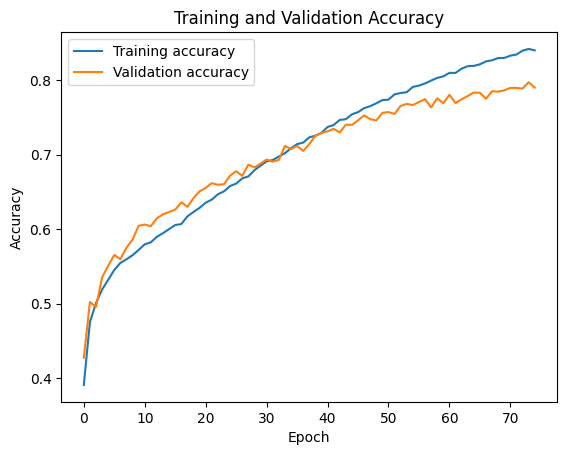

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# If y_test is one-hot encoded, convert it back to categorical
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes)
print(report)

496/496 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2693
           1       0.75      0.77      0.76      2692
           2       0.80      0.75      0.77      2692
           3       0.81      0.73      0.77      2693
           4       0.74      0.82      0.78      2384
           5       0.81      0.78      0.79      2692

    accuracy                           0.79     15846
   macro avg       0.79      0.79      0.79     15846
weighted avg       0.79      0.79      0.79     15846



496/496 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step


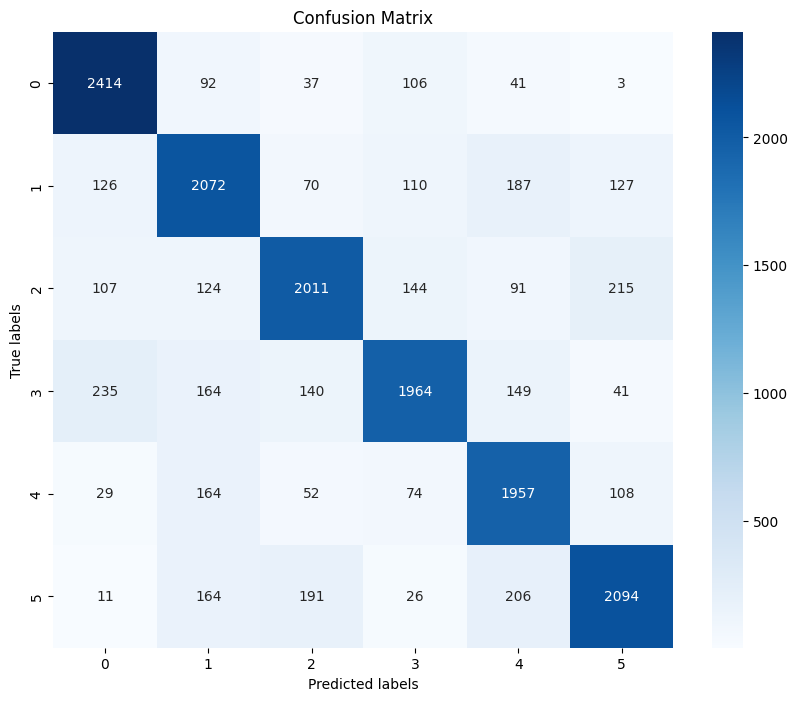

In [25]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test from one-hot to class labels if necessary
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
model.save_weights('D:/A_Graduate Project/Audio Part/my_model.weights.h5')

In [31]:
model.save('D:/A_Graduate Project/Audio Part/my_model.keras')

In [32]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from scipy.io.wavfile import write
import sounddevice as sd

# Parameters
DURATION = 5  # Duration for recording in seconds
FS = 20500  # Sampling rate
DEFAULT_FILENAME = 'output.wav'  # Default filename for recording or specifying an existing file
MODEL_PATH = 'D:\A_Graduate Project\Audio Part\my_model.keras'  # Path to the Keras model

# Class names
class_names = ['ang', 'dis', 'fea', 'hap', 'sad', 'neu']

def record_audio(duration=DURATION, fs=FS, filename=DEFAULT_FILENAME):
    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype='float64')
    sd.wait()  # Wait until recording is finished
    write(filename, fs, recording)  # Save as WAV file
    print(f"Recording finished and saved to {filename}")

def preprocess_audio(filename=DEFAULT_FILENAME):
    audio, sr = librosa.load(filename, sr=None, mono=True)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=58)
    mfccs = np.mean(mfccs, axis=1)
    mfccs = np.expand_dims(mfccs, axis=-1)
    mfccs = np.expand_dims(mfccs, axis=0)
    return mfccs

def predict_sentiment(preprocessed_audio, model_path=MODEL_PATH):
    model = load_model(model_path)
    prediction = model.predict(preprocessed_audio)[0]  # Assuming the first sample

    print("Prediction confidences:")
    for class_name, probability in zip(class_names, prediction):
        percentage = probability * 100
        print(f"{class_name}: {percentage:.2f}%")

# Main workflow
user_choice = input("Do you want to (1) record a new voice or (2) use an existing file? Enter 1 or 2: ")

if user_choice.strip() == '1':
    # Record a new voice
    record_audio()
elif user_choice.strip() == '2':
    # Use an existing file
    DEFAULT_FILENAME = input("Enter the path to the existing audio file: ")

preprocessed_audio = preprocess_audio(DEFAULT_FILENAME)
predict_sentiment(preprocessed_audio)

Recording...
Recording finished and saved to output.wav
1/1 [==============================] - 1s 1s/step
Prediction confidences:
ang: 0.01%
dis: 0.01%
fea: 99.18%
hap: 0.05%
sad: 0.05%
neu: 0.72%
